In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/utkface-new/UTKFace/26_0_2_20170104023102422.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/22_1_1_20170112233644761.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/21_1_3_20170105003215901.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/28_0_0_20170117180555824.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/17_1_4_20170103222931966.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/44_0_3_20170119201022260.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/35_0_2_20170116182734834.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/76_0_0_20170104213515132.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/36_1_0_20170116165722892.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/34_0_3_20170119200815948.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/18_1_0_20170104022856102.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/40_1_1_20170113011948248.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/45_0_0_20170117180013541.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/26_1_1_20170117153641469.jpg.c

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dense,
    Dropout,
    Flatten,
    Input
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

import random
random.seed(2)
np.random.seed(1)

if not tf.config.list_physical_devices('GPU'):
    print("No GPU detected. GPU acceleration disabled.")
else:
    print("GPU detected. GPU acceleration enabled.")


2024-02-29 03:55:10.292143: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 03:55:10.292251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 03:55:10.638251: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU detected. GPU acceleration enabled.


In [5]:
path = "/kaggle/input/utkface-new/UTKFace/"
files = os.listdir(path)
size = len(files)
print("Total samples:", size)

images = []
ages = []
genders = []
for file in files:
    image = cv2.imread(path + file, 0)
    image = cv2.resize(image, dsize=(128, 128))
    image = image.reshape((image.shape[0], image.shape[1], 1))
    images.append(image)
    split_var = file.split('_')
    ages.append(split_var[0])
    genders.append(int(split_var[1]))

def display(img):
    plt.imshow(img[:, :, 0])
    plt.set_cmap('gray')
    plt.show()

def age_group(age):
    if age >= 0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

target = np.zeros((size, 2), dtype='float32')
features = np.zeros((size, images[0].shape[0], images[0].shape[1], 1), dtype='float32')

for i in range(size):
    target[i, 0] = age_group(int(ages[i])) / 4
    target[i, 1] = int(genders[i])
    features[i] = images[i]

features = features / 255

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, shuffle=True)
print("Samples in Training:", x_train.shape[0])
print("Samples in Testing:", x_test.shape[0])

images[0].shape[0], images[0].shape[1]

Total samples: 23708
Samples in Training: 17781
Samples in Testing: 5927


(128, 128)

In [6]:
inputs = Input(shape=(128, 128, 1))
conv1 = Conv2D(64, kernel_size=(3, 3), activation='relu')(inputs)
conv2 = Conv2D(128, kernel_size=(3, 3), activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, kernel_size=(3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(256, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(128, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(256, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(128, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)

model = Model(inputs=inputs, outputs=[age_model, gender_model])

model.compile(optimizer='adam', loss=['mse', 'binary_crossentropy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 124, 124,  │     73,856 │ conv2d[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 62, 62,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 60, 60,    │    295,168 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 30, 30,    │          0 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 230400)    │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │ 58,982,656 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16)        │          0 │ dense_4[0][0],    │
│                     │                   │            │ dense_5[0][0],    │
│                     │                   │            │ dense_6[0][0],    │
│                     │                   │            │ dense_7[0][0],    │
│                     │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │ 58,982,656 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0],      │
│                     │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      2,080 │ dropout_2[2][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 16)        │        528 │ dropout_2[3][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 118,419,970 (451.74 MB)

 Trainable params: 118,419,970 (451.74 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
h = model.fit(x_train, [y_train[:, 0], y_train[:, 1]], 
              validation_data=(x_test, [y_test[:, 0], y_test[:, 1]]),
              epochs=10, batch_size=32, shuffle=True)

Epoch 1/10
  1/556 ━━━━━━━━━━━━━━━━━━━━ 5:40:34 37s/step - loss: 1.0429

I0000 00:00:1709179538.696675     166 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1709179538.718919     166 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


556/556 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 1.2218

W0000 00:00:1709179629.099404     163 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


556/556 ━━━━━━━━━━━━━━━━━━━━ 135s 177ms/step - loss: 1.2211 - val_loss: 0.6492
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 68s 122ms/step - loss: 0.6221 - val_loss: 0.3941
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 68s 122ms/step - loss: 0.4544 - val_loss: 0.3779
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 68s 122ms/step - loss: 0.4058 - val_loss: 0.3431
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 67s 121ms/step - loss: 0.3806 - val_loss: 0.3222
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 68s 121ms/step - loss: 0.3684 - val_loss: 0.3257
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 67s 121ms/step - loss: 0.3363 - val_loss: 0.3248
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 67s 121ms/step - loss: 0.3214 - val_loss: 0.3327
Epoch 9/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 67s 121ms/step - loss: 0.3017 - val_loss: 0.3207
Epoch 10/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 67s 121ms/step - loss: 0.2946 - val_loss: 0.3159


In [10]:
model.save('Gender-age.h5')

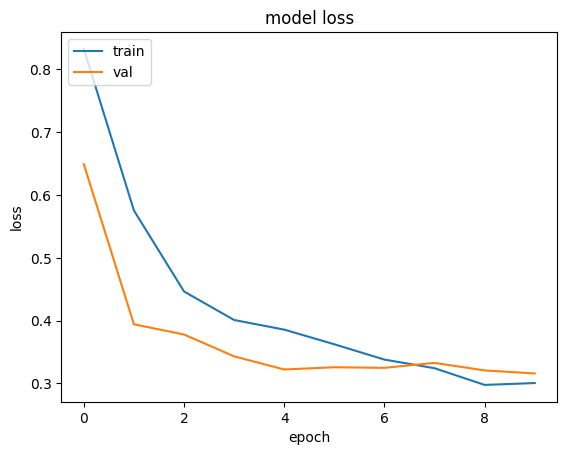

In [8]:
history = h
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()

Gender: 1 Age: 24


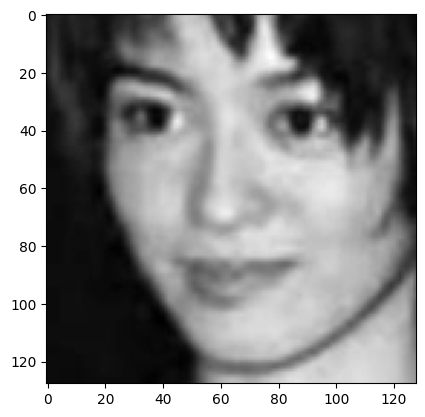

In [13]:
idx = 18
sample = images[idx]
print("Gender:",genders[idx],"Age:",ages[idx])
display(sample)

In [22]:
def get_age(distr):
    distr = distr*4
    if distr >= 0.65 and distr <= 1.4:return "0-18"
    if distr >= 1.65 and distr <= 2.4:return "19-30"
    if distr >= 2.65 and distr <= 3.4:return "31-80"
    if distr >= 3.65 and distr <= 4.4:return "80 +"
    return "Unknown"
    
def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

def get_result(sample):
    sample = sample/255
    val = model.predict(np.array([ sample ]) )    
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("Values:",val,"\nPredicted Gender:",gender,"Predicted Age:",age)

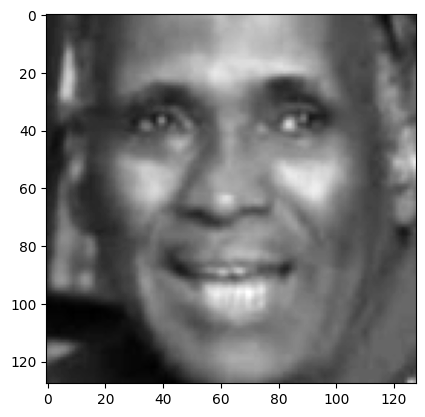

Actual Gender: Male Age: 54
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Values: [array([[0.7077259]], dtype=float32), array([[0.41152975]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


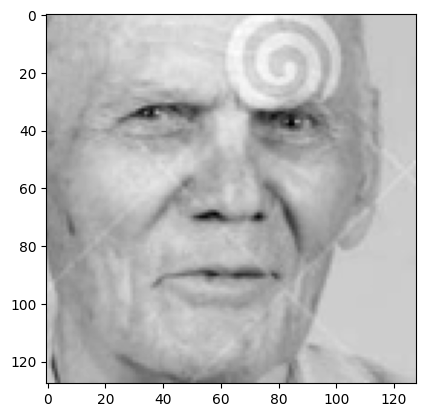

Actual Gender: Male Age: 82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Values: [array([[0.7397028]], dtype=float32), array([[0.13598925]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


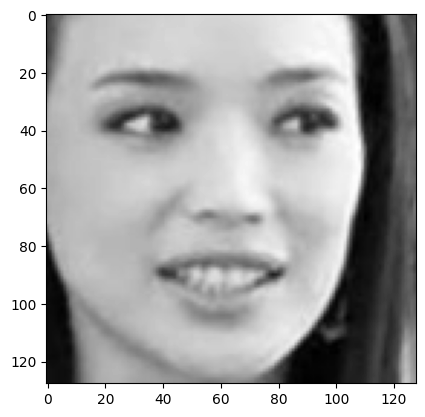

Actual Gender: Female Age: 24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Values: [array([[0.44339627]], dtype=float32), array([[0.9997877]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


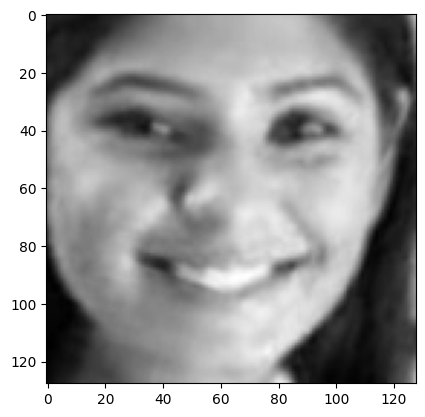

Actual Gender: Female Age: 21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Values: [array([[0.38538417]], dtype=float32), array([[0.9908701]], dtype=float32)] 
Predicted Gender: Female Predicted Age: Unknown


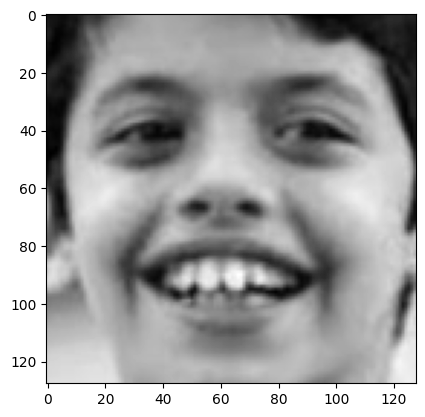

Actual Gender: Male Age: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Values: [array([[0.4681296]], dtype=float32), array([[0.37670222]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 19-30


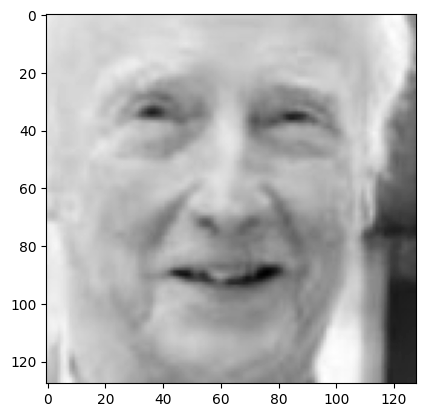

Actual Gender: Male Age: 76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Values: [array([[0.72867024]], dtype=float32), array([[0.07655881]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


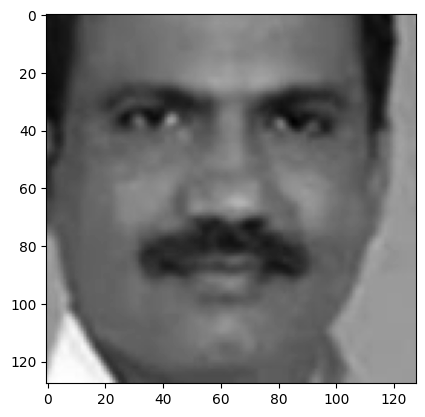

Actual Gender: Male Age: 34
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Values: [array([[0.71343046]], dtype=float32), array([[3.4605303e-09]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


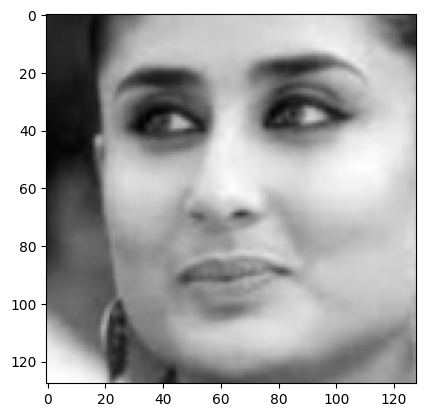

Actual Gender: Female Age: 25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Values: [array([[0.57353604]], dtype=float32), array([[0.8408728]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


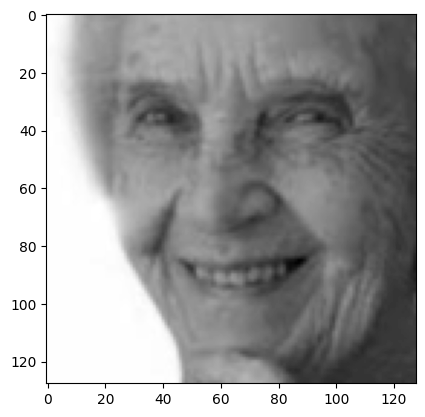

Actual Gender: Female Age: 79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Values: [array([[0.7188072]], dtype=float32), array([[0.8590091]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 31-80


In [23]:
import numpy as np
from PIL import Image
indexes = [500,59,80,2,4546,7,9,256,45]
for idx in indexes:
    sample = images[idx]
    display(sample)
    print("Actual Gender:",get_gender(genders[idx]),"Age:",ages[idx])
    res = get_result(sample)